# L'effet Djanibekov

## Description

L'effet se produit pour tout corps rigide en impesanteur — ou chute libre — qui présente trois axes principaux d'inerties différentes, selon la [description](https://fr.wikipedia.org/wiki/Effet_Djanibekov) disponible sur Wikipédia.

Ce phénomène est illustré dans une [vidéo](https://www.youtube.com/watch?v=SAQ-iIJkLzA&t=277s) sur la chaîne **Véritasium** (le lien inclue le time code qui mène directement à la séquence montrant le phénomène).

Une [première vidéo](https://www.youtube.com/watch?v=BzJsEE4yTJw) sur la chaîne **Kevin Merida** présentait une simulation numérique du phénomène.


Pour améliorer notablement la précision sur la simulation numérique, la méthode décrite dans le [document](https://www.f-legrand.fr/scidoc/srcdoc/sciphys/meca/solide/solide-pdf.pdf) rédigé par [Frédéric Legrand](https://www.f-legrand.fr/scidoc/) a été utilisée.

Les résultats de cette nouvelle simulation et les programmes associés sont accessibles dans ce notebook.

## Mise en équation

On définit le vecteur rotation $\vec{\Omega}_s$ dans le repère solidaire du corps rigide. Ce repère correspond aux axes principaux d'inertie, et les moments principaux d'inertie y sont notés $I_1$, $I_2$ et $I_3$.

\begin{equation}
\vec{\Omega}_s=\left(\begin{matrix}\Omega_1\\\Omega_2\\\Omega_3\end{matrix}\right)
\end{equation}

Par ailleurs, on définit les trois vecteurs orthonormaux orientant les axes principaux d'inertie du corps rigide, rassemblés dans les trois colonnes d'une matrice $Q$. Le mouvement s'effectue dans un référentiel inertiel et aucune force ne s'applique au solide.

L'équation dynamique est donnée ci-dessous. Elle comprend 12 variables, 3 pour les vitesses angulaires et 9 pour la matrice Q qui permettra de représenter le mouvement du solide dans le référentiel inertiel.

\begin{align}
\frac{d\Omega_1}{dt}&=\Omega_2\Omega_3\frac{(I_2 - I_3)}{I_1}\\
\frac{d\Omega_2}{dt}&=\Omega_3\Omega_1\frac{(I_3 - I_1)}{I_2}\\
\frac{d\Omega_3}{dt}&=\Omega_1\Omega_2\frac{(I_1 - I_2)}{I_3}\\
\frac{dQ}{dt}&=Q\left(\begin{matrix}
0&-\Omega_3&\Omega_2\\
\Omega_3&0&-\Omega_1\\
-\Omega_2&\Omega_1&0
\end{matrix}\right)\\
\end{align}

La résolution numérique de cette équation dynamique peut être validée en calculant le moment cinétique $\vec{\sigma}$ dans le référentiel inertiel, qui doit rester constant en théorie. Le moment cinétique $\vec{\sigma}_s$ défini sur les axes principaux d'inertie a une expression simple et donne accès à $\vec{\sigma}$ via le changement de base réalisé avec la matrice $Q$.

\begin{equation}
\vec{\sigma}=Q\vec{\sigma}_s=Q\left(\begin{matrix}I_1 \Omega_1\\I_2\Omega_2\\I_3\Omega_3\end{matrix}\right)
\end{equation}

## Code (fichier toupie.py)

In [1]:
# -*- coding: utf-8 -*-
"""
toupie

Liste des fonctions :
--------------------
toupie_video(nom='toupie_anim_8.mp4')
toupie_show()
toupie_anim(O1=0, O2=2*np.pi*10, O3=2*np.pi*0.05, tfin=2.5, tpas=2e-4, tpas_anim=5e-3, Inertie=np.array([1, 2.8, 3]))
toupie_animate(n,t,x,hx,hy,hz,h0,ht)
toupie_init()
toupie_calc(O1=0,O2=2*np.pi*10,O3=2*np.pi*0.05,tfin=2.5,tpas=2e-4,Inertie=np.array([1,2.8,3]))
rk4(f,t,y0)
equation_euler(Omega,Inertie)
equ_dyn_toupie(x,Inertie)
--------------------
@author KM (09/11/2023)
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy.linalg import norm


def toupie_video(nom='toupie_anim_8.mp4'):
    anim = toupie_anim()
    anim.save(nom, writer='ffmpeg', fps=25)
    plt.close('all')


def toupie_show():
    anim = toupie_anim()
    plt.show()


def toupie_anim(O1=0, O2=2*np.pi*10, O3=2*np.pi*0.05, tfin=2.5, tpas=2e-4, tpas_anim=5e-3, Inertie=np.array([1, 2.8, 3])):
    t = np.arange(0, tfin+tpas, tpas)
    Q = np.eye(3)
    x0 = np.concatenate([[O1], [O2], [O3], np.reshape(Q, 9)])
    [t, x] = rk4(lambda t, x: equ_dyn_toupie(x, Inertie), t, x0)
    fig, hx, hy, hz, h0, ht = toupie_init()
    anim = animation.FuncAnimation(fig, lambda n: toupie_animate(n, t, x, hx, hy, hz, h0, ht),
                                   frames=range(
                                       0, len(t), int(tpas_anim/tpas)),
                                   interval=40, blit=True, repeat=True)
    return anim


def toupie_animate(n, t, x, hx, hy, hz, h0, ht):
    Q = np.reshape(x[n, 3:12], (3, 3))
    hx.set_data_3d([-Q[0, 0], Q[0, 0]],
                   [-Q[1, 0], Q[1, 0]], [-Q[2, 0], Q[2, 0]])
    hy.set_data_3d([0, Q[0, 1]/2], [0, Q[1, 1]/2], [0, Q[2, 1]/2])
    hz.set_data_3d([-Q[0, 2]/4, Q[0, 2]/4], [-Q[1, 2]/4,
                   Q[1, 2]/4], [-Q[2, 2]/4, Q[2, 2]/4])
    h0.set_data_3d([0, Q[0, 1]/2], [0, Q[1, 1]/2], [-1, -1])
    ht.set_text('t={0:.2f}s'.format(t[n]))
    return hx, hy, hz, h0, ht


def toupie_init():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    hx, = ax.plot([], [], [], 'g', linewidth=2, label='X')
    hy, = ax.plot([], [], [], 'r', linewidth=4, label='Y')
    hz, = ax.plot([], [], [], 'b', linewidth=2, label='Z')
    h0, = ax.plot([], [], [], 'k', linewidth=4, label='ombre')
    ht = ax.text(-1, -1, 2, [])
    ax.axes.set_xlim3d(left=-1.2, right=1.2)
    ax.axes.set_ylim3d(bottom=-1.2, top=1.2)
    ax.axes.set_zlim3d(bottom=-1, top=1)
    ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
    ax.legend()
    return fig, hx, hy, hz, h0, ht


def toupie_calc(O1=0, O2=2*np.pi*10, O3=2*np.pi*0.05, tfin=2.5, tpas=2e-4, Inertie=np.array([1, 2.8, 3])):
    t = np.arange(0, tfin+tpas, tpas)
    Q = np.eye(3)
    x0 = np.concatenate([[O1], [O2], [O3], np.reshape(Q, 9)])
    [t, x] = rk4(lambda t, x: equ_dyn_toupie(x, Inertie), t, x0)

    MomentCinetique = np.zeros((len(t), 3))
    for n in range(0, len(t)):
        Q = np.reshape(x[n, 3:12], (3, 3))
        MomentCinetique[n, :] = (Q@(Inertie*x[n, 0:3]).T).T

    M0 = MomentCinetique[0, :]
    fig, ax = plt.subplots(3, 1)
    ax[0].plot(t, (MomentCinetique[:, 0]-M0[0])/norm(M0), 'r')
    ax[0].set_title('Variation du moment cinétique dans le repère fixe')
    ax[0].set_ylabel('$\dfrac{\Delta\sigma_X}{\|\sigma\|}$')
    ax[0].grid('on')
    ax[1].plot(t, (MomentCinetique[:, 1]-M0[1])/norm(M0), 'g')
    ax[1].set_ylabel('$\dfrac{\Delta\sigma_Y}{\|\sigma\|}$')
    ax[1].grid('on')
    ax[2].plot(t, (MomentCinetique[:, 2]-M0[2])/norm(M0), 'b')
    ax[2].set_ylabel('$\dfrac{\Delta\sigma_Z}{\|\sigma\|}$')
    ax[2].set_xlabel('temps (en s)')
    ax[2].grid('on')

    plt.figure()
    plt.plot(t, x[:, 0:3]/(2*np.pi))
    plt.legend(['$\Omega_1$', '$\Omega_2$', '$\Omega_3$'])
    plt.grid('on')
    plt.xlabel('temps (en s)')
    plt.ylabel('vitesse (en tours/seconde)')
    plt.title(
        f'vitesses initiales $\Omega_1$={O1/(2*np.pi):.2f}, $\Omega_2$={O2/(2*np.pi):.2f},$\Omega_3$={O3/(2*np.pi):.2f}')

    plt.show()


def rk4(f, t, y0):
    y = np.zeros((len(t), len(y0)))
    k1 = np.zeros(len(y0))
    k2 = np.copy(k1)
    k3 = np.copy(k1)
    k4 = np.copy(k1)
    y[0, :] = y0[:]
    for n in np.arange(1, len(t)):
        yprec = y[n-1]
        tprec = t[n-1]
        h = t[n]-tprec
        k1[:] = f(tprec, yprec)
        k2[:] = f(tprec+h/2, yprec+(h/2)*k1)
        k3[:] = f(tprec+h/2, yprec+(h/2)*k2)
        k4[:] = f(tprec+h, yprec+h*k3)
        y[n, :] = yprec+(h/6)*(k1+2*k2+2*k3+k4)
    return t, y


def equation_euler(Omega, Inertie):
    I1 = Inertie[0]
    I2 = Inertie[1]
    I3 = Inertie[2]
    O1 = Omega[0]
    O2 = Omega[1]
    O3 = Omega[2]
    Omegap = np.zeros(3)
    Omegap[0] = O2*O3*(I2-I3)/I1
    Omegap[1] = O3*O1*(I3-I1)/I2
    Omegap[2] = O1*O2*(I1-I2)/I3
    return Omegap


def equ_dyn_toupie(x, Inertie):
    xp = np.zeros(12)
    O1 = x[0]
    O2 = x[1]
    O3 = x[2]
    OmegaS = [[0, -O3, O2], [O3, 0, -O1],
              [-O2, O1, 0]]
    xp[0:3] = equation_euler([O1, O2, O3], Inertie)
    Q = np.reshape(x[3:12], (3, 3))
    Qp = Q@OmegaS
    xp[3:12] = np.reshape(Qp, 9)
    return xp


## Validation de la simulation

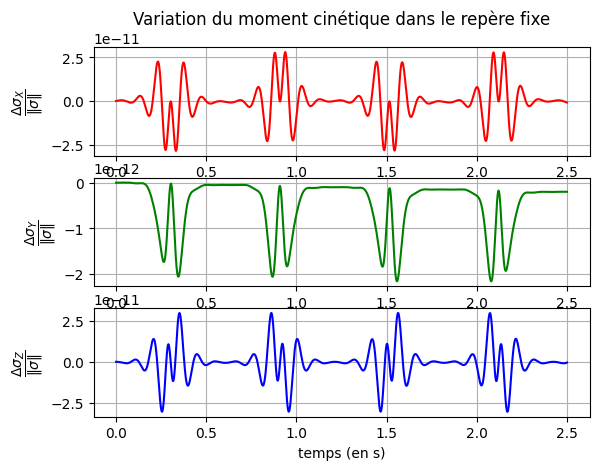

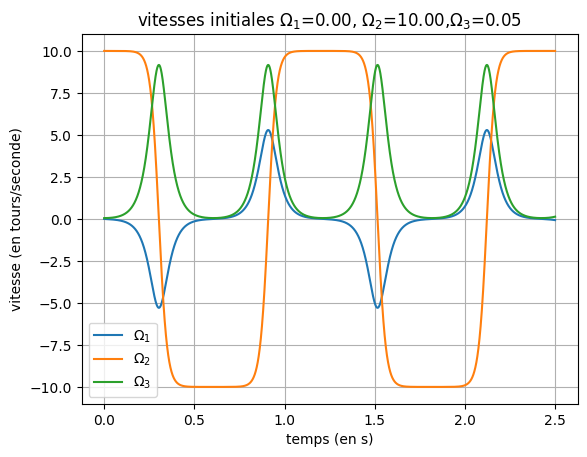

In [2]:
toupie_calc()

## Construction de l'animation

In [3]:
toupie_video(nom='toupie_anim.mp4')

## Visualisation de l'animation

In [4]:
import moviepy.editor
moviepy.editor.ipython_display('toupie_anim.mp4')